In [1]:
import sys
sys.path.insert(1, '../src/')
sys.path.insert(1, './utils/')
import classifier
from classification_metrics import binarize_labels, _classification_report, get_thresholds, get_classification_metrics, get_indices, to_colorful_label_predictions
from cam_visualization import _plot_cams

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
## Initialize required variables

_num_classes = 3
_num_gpus = 1
_img_size = 480
_batch_size = 24
weights_path = "/home/ubuntu/anudeep/covid19/model_weights/multi_class/densenet121_softmax_oversampling_try3_09.hdf5"
#val_df_path = "./covid_chexpert_val_df.pkl"
#predictions_path = "../predictions/densenet121_softmax_oversampling_try3_09.npy"#"../predictions/9cls_BCE_sigmoid_32.npy"
data_path = "/home/ubuntu/anudeep/covid19/data/covidx/data/test/"#/home/anudeep/data/"


## Load validation dataframe and predictions

def make_dataframes():
    txt_path = "/home/ubuntu/anudeep/covid19/data/covidx/"
    image_path = "/home/ubuntu/anudeep/covid19/datacovidx/data/"
    train_txt = open(txt_path+'train_split.txt', "r").readlines()
    test_txt = open(txt_path+'test_split.txt', "r").readlines()
    
    test_to_df = []
    for k in test_txt:
        temp = []
        fname = k.split(" ")[1]
        label = k.split(" ")[2]
        site = k.split(" ")[-1][:-1]
        test_to_df.append([fname, label, site])


    train_to_df = []
    for k in train_txt:
        temp = []
        fname = k.split(" ")[1]
        label = k.split(" ")[2]
        site = k.split(" ")[-1][:-1]
        train_to_df.append([fname, label, site])
        
    test_df = pd.DataFrame(test_to_df, columns = ['Path', 'feature_string', 'site'])
    train_df = pd.DataFrame(train_to_df, columns = ['Path', 'feature_string', 'site'])
    
    return train_df, test_df



full_train_df, full_val_df = make_dataframes()




val_df = full_val_df#pd.read_pickle(val_df_path)
#y_pred_keras = np.load(predictions_path)
classifier_8 = classifier.Classifier(_img_size, _num_gpus, _num_classes, _batch_size)
classifier_8.datagen_init_valid_old(val_df, data_path)


y_labels = classifier_8.validation_generator.labels#binarize_labels(classifier_8)#

_class_names = list(classifier_8.validation_generator.class_indices.keys())
# _class_names[0] = "Other"
# #_class_names[6] = "Healthy"
print("\n", list(classifier_8.validation_generator.class_indices.keys()))

maps = {'COVID-19':0, 'normal': 1, 'pneumonia':2}
y_labels = []
for index, row in val_df.iterrows():
    y_labels.append(maps[row['feature_string']])
y_labels = np.array(y_labels)
#y_pred_keras = np.argmax(y_pred_keras, axis=-1)

Found 474 validated image filenames belonging to 3 classes.

 ['COVID-19', 'normal', 'pneumonia']


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
temp =[]
for k in y_labels:
    temp.append([k])
y_labels = mlb.fit_transform(temp)

In [10]:
print(weights_path)
classifier_8.build_model(load_previous_weights=False, if_grad=True)
classifier_8.model.load_weights(weights_path)
print(classifier_8.model.output)
y_pred_keras = classifier_8.model.predict_generator(classifier_8.validation_generator)

/home/ubuntu/anudeep/covid19/model_weights/multi_class/densenet121_softmax_oversampling_try3_09.hdf5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
[<tf.Tensor 'dense_7/Softmax:0' shape=(None, 3) dtype=float32>, <tf.Tensor 'batch_normalization_3/batchnorm/add_1:0' shape=(None, 512) dtype=float32>, <tf.Tensor 'relu/Relu_1:0' shape=(None, 15, 15, 1024) dtype=float32>]
Instructions for updating:
Please use Model.predict, which supports generators.
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


In [11]:
y_pred_keras = y_pred_keras[0]
y_pred_keras = np.argmax(y_pred_keras, axis=-1)

# Class activation maps

In [12]:
# Choose the class and error

_class = 'COVID-19'
_index = _class_names.index(_class)
print(_index)

# You can choose FN or FP

_error_type = 'FN'

# Get the indices
inv_maps = {0: 'COVID-19', 1:'normal', 2:'pneumonia'}
indices = list(val_df.index)
y_look_for = maps[_class]
fps = [] # pred: 1 ; GT: 0
to_color_fps = [[],[],[]]
fns = [] # pred: 0 ; GT: 1
to_color_fns = [[],[],[]]
print(y_look_for)

for k in indices:
    y_lab = maps[val_df.iloc[k]["feature_string"]]
    if y_lab != y_look_for and y_pred_keras[k] == y_look_for:
        fps.append(k)
        to_color_fps[0].append([val_df.iloc[k]["feature_string"]])
        to_color_fps[1].append([inv_maps[y_pred_keras[k]]])
        to_color_fps[2].append([])
    elif y_lab == y_look_for and y_pred_keras[k] != y_look_for:
        ##print(val_df.iloc[k]["Path"])
        fns.append(k)
        to_color_fns[0].append([val_df.iloc[k]["feature_string"]])
        to_color_fns[1].append([inv_maps[y_pred_keras[k]]])
        to_color_fns[2].append([])
        
print(len(fps), len(fns))
if _error_type == 'FP':
    _desired_image_indices = fps
    to_color_labs = to_color_fps
elif _error_type == 'FN':
    _desired_image_indices = fns
    to_color_labs = to_color_fns

0


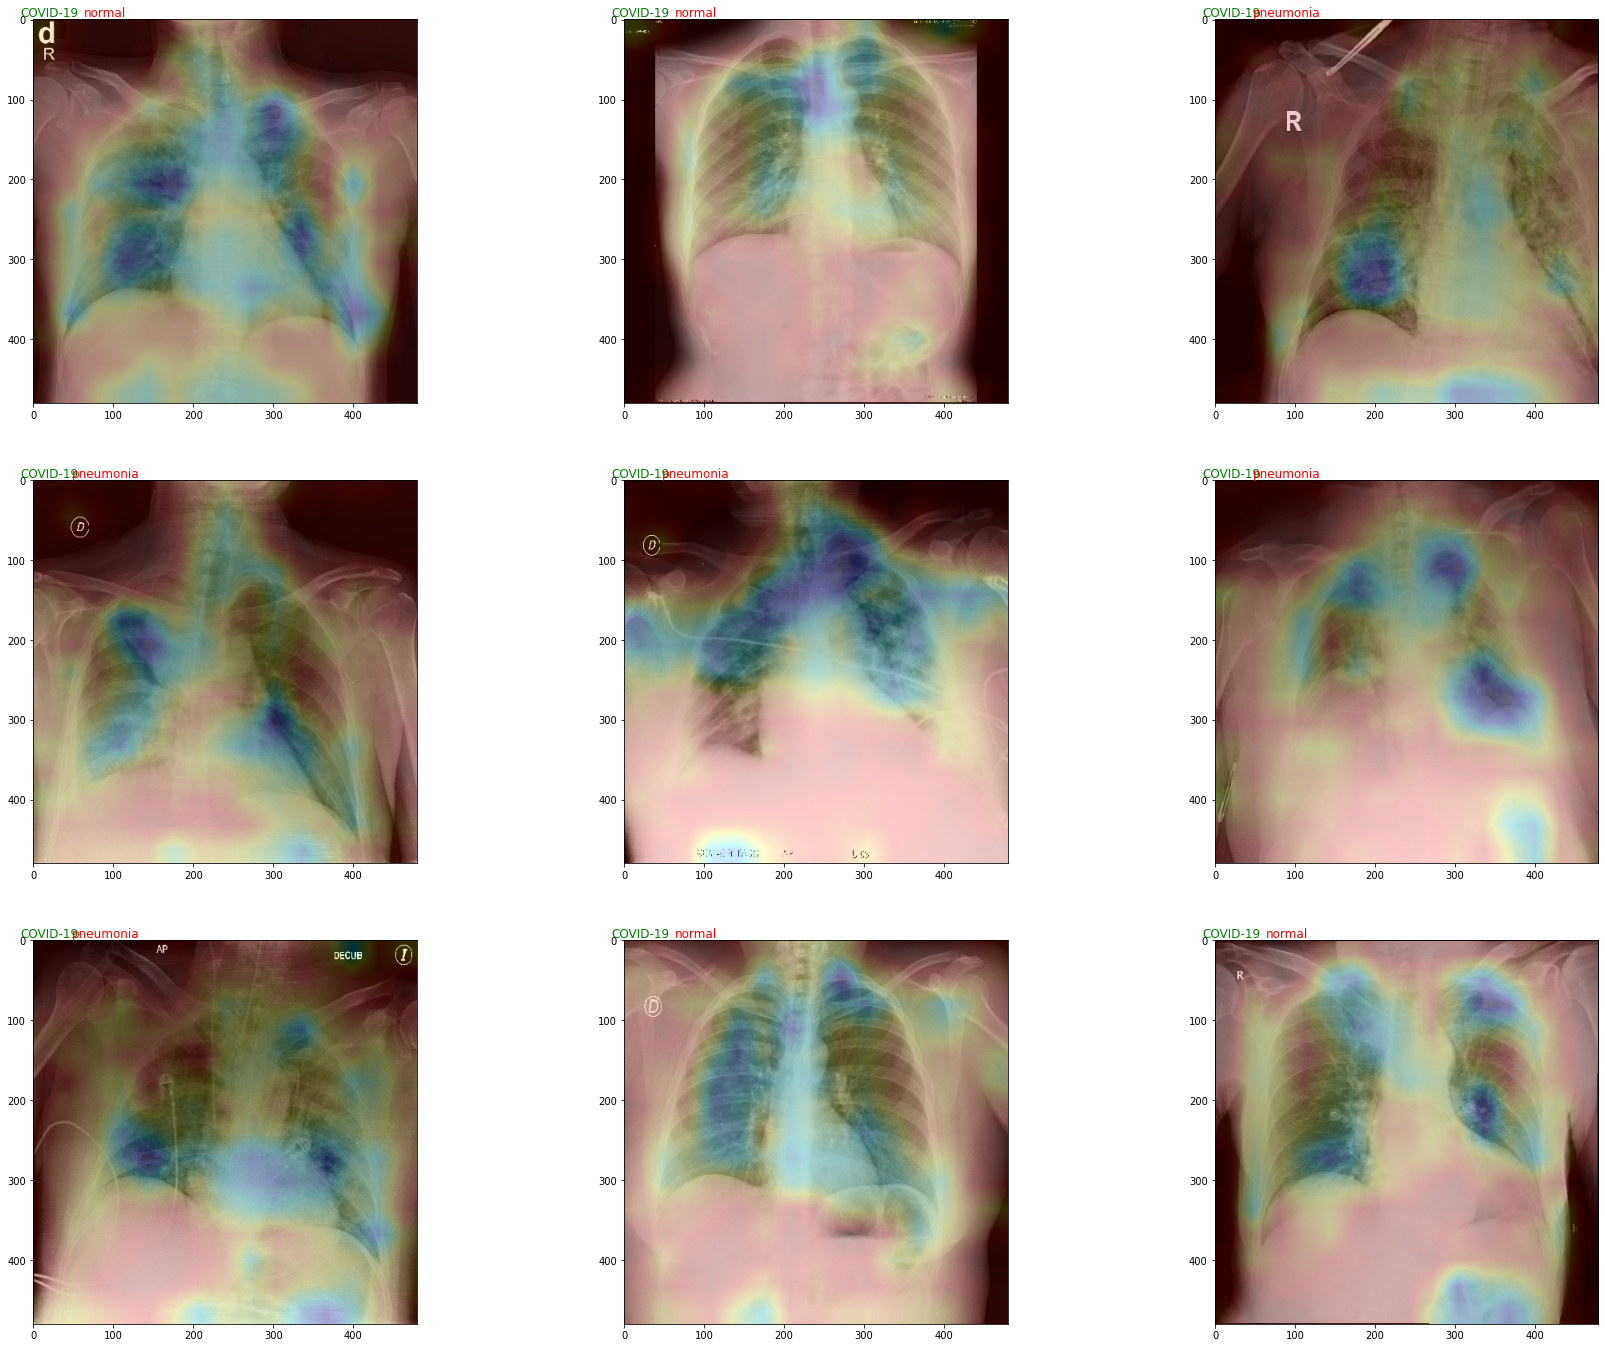

In [18]:
ret = _plot_cams(_desired_image_indices, _index, classifier_8, to_color_labs) 

# Random stuff

In [15]:
full_train_df_covid = full_val_df[full_val_df["feature_string"] == "COVID-19"]

In [16]:
sites = np.array(list(full_train_df_covid["site"]))
print(np.unique(sites, return_counts=True))

(array(['actmed', 'cohen', 'fig1', 'ricord'], dtype='<U6'), array([ 33,  25,  11, 200]))
